In [3]:
%matplotlib inline

In [4]:
import brian2
import numpy as np
import matplotlib.pylab as plt
import itertools, scipy.special
from scipy.ndimage.filters import gaussian_filter1d

WARNING    /var/folders/bj/k_p2q7gs6_q7wz79gznbymvr0000gn/T/ipykernel_48037/3025630084.py:5: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d
 [py.warnings]


A large dictionary storing all networks parameters
######################################################

In [4]:
Model = {
    ## ---------------------------------------------------------------------------------
    ### Initialisation by default parameters
    ## UNIT SYSTEM is : ms, mV, pF, nS, pA, Hz (arbitrary and unconsistent, so see code)
    ## ---------------------------------------------------------------------------------
    # numbers of neurons in population
    'N_RecExc':4000, 'N_RecInh':1000, 'N_AffExc':100, 'N_DsInh':500,
    # synaptic weights (nS)
    'Q_RecExc_RecExc':2., 'Q_RecExc_RecInh':2., 
    'Q_RecInh_RecExc':10., 'Q_RecInh_RecInh':10., 
    'Q_AffExc_RecExc':4., 'Q_AffExc_RecInh':4., 
    'Q_AffExc_DsInh':4.,
    'Q_DsInh_RecInh':10., 
    # synaptic time constants (ms)
    'Tse':5., 'Tsi':5.,
    # synaptic reversal potentials (mV)
    'Ee':0., 'Ei': -80.,
    # connectivity parameters (proba.)
    'p_RecExc_RecExc':0.05, 'p_RecExc_RecInh':0.05, 
    'p_RecInh_RecExc':0.05, 'p_RecInh_RecInh':0.05, 
    'p_DsInh_RecInh':0.05, 
    'p_AffExc_RecExc':0.1, 'p_AffExc_RecInh':0.1, 
    'p_AffExc_DsInh':0.075,
    # afferent stimulation (Hz)
    'F_AffExc':10.,
    # simulation parameters (ms)
    'dt':0.1, 'SEED':3, # low by default, see later
    ## ---------------------------------------------------------------------------------
    # === cellular properties (based on AdExp), population by population ===
    # --> Excitatory population (RecExc, recurrent excitation)
    'RecExc_Gl':10., 'RecExc_Cm':200.,'RecExc_Trefrac':5.,
    'RecExc_El':-70., 'RecExc_Vthre':-50., 'RecExc_Vreset':-70., 'RecExc_delta_v':0.,
    'RecExc_a':0., 'RecExc_b': 0., 'RecExc_tauw':1e9,
    # --> Inhibitory population (RecInh, recurrent inhibition)
    'RecInh_Gl':10., 'RecInh_Cm':200.,'RecInh_Trefrac':5.,
    'RecInh_El':-70., 'RecInh_Vthre':-53., 'RecInh_Vreset':-70., 'RecInh_delta_v':0.,
    'RecInh_a':0., 'RecInh_b': 0., 'RecInh_tauw':1e9,
    # --> Disinhibitory population (DsInh, disinhibition)
    'DsInh_Gl':10., 'DsInh_Cm':200.,'DsInh_Trefrac':5.,
    'DsInh_El':-70., 'DsInh_Vthre':-50., 'DsInh_Vreset':-70., 'DsInh_delta_v':0.,
    'DsInh_a':0., 'DsInh_b': 0., 'DsInh_tauw':1e9,
    ## ---------------------------------------------------------------------------------
    # === afferent population waveform:
    'Faff1':4.,'Faff2':20.,'Faff3':8.,
    'DT':900., 'rise':50.
}

def built_up_neuron_params(Model,
                           NRN_KEY, N=1):
    """ we construct a dictionary from the """
    params = {'name':NRN_KEY, 'N':N}
    keys = ['Gl', 'Cm','Trefrac', 'El', 'Vthre', 'Vreset']
    for k in keys:
        params[k] = Model[NRN_KEY+'_'+k]
    return params

def get_membrane_equation(neuron_params, synaptic_array,\
                          verbose=False):
    ## -- membrane equation: Vm dynamics
    eqs = """
    dV/dt = (%(Gl)f*nS*(%(El)f*mV - V) + I)/(%(Cm)f*pF) : volt (unless refractory) """ % neuron_params
    
    ## -- synaptic currents: 1) adding all synaptic currents to the membrane equation via the I variable
    eqs += """
        I = I0 """
    for synapse in synaptic_array:
        if synapse['pconn']>0:
            # loop over each presynaptic element onto this target
            Gsyn = 'G'+synapse['name']
            eqs += '+'+Gsyn+'*(%(Erev)f*mV - V)' % synapse
    eqs += ' : amp'

    ## --  synaptic currents: 2) constructing the temporal dynamics of the synaptic conductances
    for synapse in synaptic_array:
        # loop over each presynaptic element onto this target
        if synapse['pconn']>0:
            Gsyn = 'G'+synapse['name']
            eqs += """
            """+'d'+Gsyn+'/dt = -'+Gsyn+'*(1./(%(Tsyn)f*ms)) : siemens' % synapse
    eqs += """
        I0 : amp """

    if verbose:
        print('------------------------------------------------------------------')
        print('==> Neuron Type', neuron_params['name'])
        print('--------> with parameters:', neuron_params)
        print('--------> Equations:', eqs)
        
    neurons = brian2.NeuronGroup(neuron_params['N'], model=eqs,
                                 method='euler',
                                 refractory=str(neuron_params['Trefrac'])+'*ms',
                                 threshold='V>'+str(neuron_params['Vthre'])+'*mV',
                                 reset='V='+str(neuron_params['Vreset'])+'*mV')
    return neurons


def get_syn_and_conn_matrix(Model,
                            POPULATIONS,
                            AFFERENT_POPULATIONS=[],
                            verbose=False):

    SOURCE_POPULATIONS = POPULATIONS+AFFERENT_POPULATIONS
    
    # creating empty arry of objects (future dictionnaries)
    M = np.empty((len(SOURCE_POPULATIONS), len(POPULATIONS)), dtype=object)
    # default initialisation
    for i, j in itertools.product(range(len(SOURCE_POPULATIONS)), range(len(POPULATIONS))):
        source_pop, target_pop = SOURCE_POPULATIONS[i], POPULATIONS[j]
        if len(source_pop.split('Exc'))>1:
            Erev, Ts = Model['Ee'], Model['Tse'] # common Erev and Tsyn to all excitatory currents
        elif len(source_pop.split('Inh'))>1:
            Erev, Ts = Model['Ei'], Model['Tsi'] # common Erev and Tsyn to all inhibitory currents
        else:
            print(' /!\ SOURCE POP COULD NOT BE CLASSIFIED AS Exc or Inh /!\ ')
            print('-----> set to Exc by default')
            Erev, Ts = Model['Ee'], Model['Tse']

        # CONNECTION PROBABILITY AND SYNAPTIC WEIGHTS
        if ('p_'+source_pop+'_'+target_pop in Model.keys()) and ('Q_'+source_pop+'_'+target_pop in Model.keys()):
            pconn, Qsyn = Model['p_'+source_pop+'_'+target_pop], Model['Q_'+source_pop+'_'+target_pop]
        else:
            if verbose:
                print('No connection for:', source_pop,'->', target_pop)
            pconn, Qsyn = 0., 0.
                
        M[i, j] = {'pconn': pconn, 'Q': Qsyn,
                   'Erev': Erev, 'Tsyn': Ts,
                   'name':source_pop+target_pop}

    return M

def build_populations(Model,
                      POPULATIONS,
                      AFFERENT_POPULATIONS=[],
                      with_Vm=2,
                      verbose=False):
    """
    sets up the neuronal populations
    and construct a network object containing everything: NTWK
    """

    ## NEURONS AND CONNECTIVITY MATRIX
    NEURONS = []
    for pop in POPULATIONS:
        NEURONS.append({'name':pop, 'N':Model['N_'+pop]})

    NTWK = {'NEURONS':NEURONS, 'Model':Model,
            'POPULATIONS':np.array(POPULATIONS),
            'M':get_syn_and_conn_matrix(Model,
                                        POPULATIONS,
                                        AFFERENT_POPULATIONS=AFFERENT_POPULATIONS,
                                        verbose=verbose)}
    
    ########################################################################
    ####  Setting up 
    ########################################################################
    
    NTWK['POPS'] = []
    for ii, nrn in enumerate(NEURONS):
        neuron_params = built_up_neuron_params(Model,
                                               nrn['name'], N=nrn['N'])
        NTWK['POPS'].append(get_membrane_equation(neuron_params,
                                                  NTWK['M'][:,ii],
                                                  verbose=verbose))
        nrn['params'] = neuron_params

    ########################################################################
    #### Recordings
    ########################################################################
    
    NTWK['POP_ACT'] = []
    for pop in NTWK['POPS']:
        NTWK['POP_ACT'].append(brian2.PopulationRateMonitor(pop))

    NTWK['RASTER'] = []
    for pop in NTWK['POPS']:
        NTWK['RASTER'].append(brian2.SpikeMonitor(pop))
        
    if with_Vm>0:
        NTWK['VMS'] = []
        for pop in NTWK['POPS']:
            NTWK['VMS'].append(brian2.StateMonitor(pop, 'V', record=np.arange(with_Vm)))
            
    NTWK['PRE_SPIKES'], NTWK['PRE_SYNAPSES'] = [], [] # for future afferent inputs
    
    return NTWK

def build_up_recurrent_connections(NTWK, SEED=1, verbose=False):
    """
    Construct the synapses from the connectivity matrix 
    """
    CONN = np.empty((len(NTWK['POPS']), len(NTWK['POPS'])), dtype=object)
    CONN2 = []

    np.random.seed(SEED)

    if verbose:
        print('------------------------------------------------------')
        print('drawing random connections [...]')
        print('------------------------------------------------------')
        
    for ii, jj in itertools.product(range(len(NTWK['POPS'])), range(len(NTWK['POPS']))):
        if (NTWK['M'][ii,jj]['pconn']>0) and (NTWK['M'][ii,jj]['Q']!=0):
            CONN[ii,jj] = brian2.Synapses(NTWK['POPS'][ii], NTWK['POPS'][jj], model='w:siemens',\
                               on_pre='G'+NTWK['M'][ii,jj]['name']+'_post+=w')
            # N.B. the following brian2 settings:
            # CONN[ii,jj].connect(p=NTWK['M'][ii,jj]['pconn'], condition='i!=j')
            # does not fix synaptic numbers, so we draw manually the connections
            N_per_cell = int(NTWK['M'][ii,jj]['pconn']*NTWK['POPS'][ii].N)
            if ii==jj: # need to take care of no autapse
                i_rdms = np.concatenate([\
                                np.random.choice(
                                    np.delete(np.arange(NTWK['POPS'][ii].N), [iii]), N_per_cell)\
                                          for iii in range(NTWK['POPS'][jj].N)])
            else:
                i_rdms = np.concatenate([\
                                np.random.choice(np.arange(NTWK['POPS'][ii].N), N_per_cell)\
                                          for jjj in range(NTWK['POPS'][jj].N)])
            j_fixed = np.concatenate([np.ones(N_per_cell,dtype=int)*jjj for jjj in range(NTWK['POPS'][jj].N)])
            CONN[ii,jj].connect(i=i_rdms, j=j_fixed) 
            CONN[ii,jj].w = NTWK['M'][ii,jj]['Q']*brian2.nS
            CONN2.append(CONN[ii,jj])

    NTWK['REC_SYNAPSES'] = CONN2


WARNING    <>:114: SyntaxWarning: invalid escape sequence '\ '
 [py.warnings]
WARNING    <>:114: SyntaxWarning: invalid escape sequence '\ '
 [py.warnings]
WARNING    /var/folders/bj/k_p2q7gs6_q7wz79gznbymvr0000gn/T/ipykernel_42639/1809258317.py:114: SyntaxWarning: invalid escape sequence '\ '
  print(' /!\ SOURCE POP COULD NOT BE CLASSIFIED AS Exc or Inh /!\ ')
 [py.warnings]


################## AFFERENT INPUTS ####################
#######################################################

In [5]:
def waveform(t, Model):
    waveform = 0*t
    # first waveform
    for tt, fa in zip(\
         2.*Model['rise']+np.arange(3)*(3.*Model['rise']+Model['DT']),
                      [Model['Faff1'], Model['Faff2'], Model['Faff3']]):
        waveform += fa*\
             (1+scipy.special.erf((t-tt)/Model['rise']))*\
             (1+scipy.special.erf(-(t-tt-Model['DT'])/Model['rise']))/4
    return waveform

def set_spikes_from_time_varying_rate(time_array, rate_array, N, Nsyn, SEED=1):
    """
    generates an inhomogeneous Poisson process from a time-varying waveform in Hz
    """
    np.random.seed(SEED) # setting the seed !
    
    ## time_array in ms !!
    # so multplying rate array
    
    indices, times = [], []
    DT = (time_array[1]-time_array[0])
    
    # trivial way to generate inhomogeneous poisson events
    for it in range(len(time_array)):
        rdm_num = np.random.random(N)
        for ii in np.arange(N)[rdm_num<DT*Nsyn*rate_array[it]*1e-3]:
            indices.append(ii) # all the indices
            times.append(time_array[it]) # all the same time !

    return np.array(indices), np.array(times)*brian2.ms

def construct_feedforward_input(NTWK,
                                target_pop, afferent_pop,\
                                t, rate_array,\
                                verbose=False,
                                SEED=1):
    """
    This generates an input asynchronous from post synaptic neurons to post-synaptic neurons

    POPS and AFFERENCE_ARRAY should be 1D arrrays as their is only one 
    source population

    'pop_for_conductance' is the string identifying the source conductance
    that will be incremented by the afferent input !!
    """

    Model = NTWK['Model']
    
    # extract parameters of the afferent input
    Nsyn = Model['p_'+afferent_pop+'_'+target_pop]*Model['N_'+afferent_pop]
    Qsyn = Model['Q_'+afferent_pop+'_'+target_pop]

    #finding the target pop in the brian2 objects
    ipop = np.argwhere(NTWK['POPULATIONS']==target_pop).flatten()[0]
    
    if Nsyn>0:
        if verbose:
            print('drawing Poisson process for afferent input [...]')
        indices, times = set_spikes_from_time_varying_rate(\
                            t, rate_array,\
                            NTWK['POPS'][ipop].N, Nsyn, SEED=(SEED+2)**2%100)
        spikes = brian2.SpikeGeneratorGroup(NTWK['POPS'][ipop].N, indices, times)
        pre_increment = 'G'+afferent_pop+target_pop+' += w'
        synapse = brian2.Synapses(spikes, NTWK['POPS'][ipop], on_pre=pre_increment,\
                                        model='w:siemens')
        synapse.connect('i==j')
        synapse.w = Qsyn*brian2.nS

        NTWK['PRE_SPIKES'].append(spikes)
        NTWK['PRE_SYNAPSES'].append(synapse)
        
    else:
        print('Nsyn = 0 for', afferent_pop+'_'+target_pop)
    

## --------------- Initial Condition ------------------------ ##
################################################################

In [6]:
def initialize_to_rest(NTWK):
    """
    Vm to resting potential and conductances to 0
    """
    for ii in range(len(NTWK['POPS'])):
        NTWK['POPS'][ii].V = NTWK['NEURONS'][ii]['params']['El']*brian2.mV
        for jj in range(len(NTWK['POPS'])):
            if NTWK['M'][jj,ii]['pconn']>0: # if connection
                exec("NTWK['POPS'][ii].G"+NTWK['M'][jj,ii]['name']+" = 0.*brian2.nS")

## ----- Run ----- ##
#####################

In [7]:

def collect_and_run(NTWK, verbose=False):
    """
    collecting all the Brian2 objects and running the simulation
    """
    NTWK['dt'], NTWK['tstop'] = NTWK['Model']['dt'], NTWK['Model']['tstop'] 
    brian2.defaultclock.dt = NTWK['dt']*brian2.ms
    net = brian2.Network(brian2.collect())
    OBJECT_LIST = []
    for key in ['POPS',
                'REC_SYNAPSES', 'RASTER',
                'POP_ACT', 'VMS',
                'PRE_SPIKES', 'PRE_SYNAPSES']:
        if key in NTWK.keys():
            net.add(NTWK[key])

    print('running simulation [...]')
    net.run(NTWK['tstop']*brian2.ms)
    return net

def run_3pop_ntwk_model(Model,
                        filename='data/sas.h5',
                        with_Vm=4,
                        verbose=False,
                        SEED=3):

    print('initializing simulation [...]')
    NTWK = build_populations(Model,
                             ['RecExc', 'RecInh', 'DsInh'],
                             AFFERENT_POPULATIONS=['AffExc'],
                             with_Vm=with_Vm,
                             verbose=verbose)

    build_up_recurrent_connections(NTWK,
                                   SEED=Model['SEED'], verbose=verbose)


    Model['tstop'] = Model['rise']+3*(3.*Model['rise']+Model['DT'])
    NTWK['t_array'] = np.arange(int(Model['tstop']/Model['dt']))*Model['dt']
    NTWK['faff_waveform'] = waveform(NTWK['t_array'], Model)

    for i, tpop in enumerate(['RecExc', 'RecInh', 'DsInh']): # both on excitation and inhibition
        construct_feedforward_input(NTWK, tpop, 'AffExc',
                                    NTWK['t_array'],
                                    NTWK['faff_waveform'],
                                    verbose=verbose,
                                    SEED=int(37*SEED+i)%13)

    initialize_to_rest(NTWK)
    
    network_sim = collect_and_run(NTWK,
                                  verbose=verbose)
    
    print('-> done !')

    return NTWK
    


usage: ipykernel_launcher.py [-h] [-v]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/cocconat/Library/Jupyter/runtime/kernel-v2-14617esrRBhiBuRRF.json


SystemExit: 2

WARNING    /Users/cocconat/.virtualenvs/brian/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3680: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
 [py.warnings]


initializing simulation [...]
No connection for: RecExc -> DsInh
No connection for: RecInh -> DsInh
No connection for: DsInh -> RecExc
No connection for: DsInh -> DsInh
------------------------------------------------------------------
==> Neuron Type RecExc
--------> with parameters: {'name': 'RecExc', 'N': 4000, 'Gl': 10.0, 'Cm': 200.0, 'Trefrac': 5.0, 'El': -70.0, 'Vthre': -50.0, 'Vreset': -70.0}
--------> Equations: 
    dV/dt = (10.000000*nS*(-70.000000*mV - V) + I)/(200.000000*pF) : volt (unless refractory) 
        I = I0 +GRecExcRecExc*(0.000000*mV - V)+GRecInhRecExc*(-80.000000*mV - V)+GAffExcRecExc*(0.000000*mV - V) : amp
            dGRecExcRecExc/dt = -GRecExcRecExc*(1./(5.000000*ms)) : siemens
            dGRecInhRecExc/dt = -GRecInhRecExc*(1./(5.000000*ms)) : siemens
            dGAffExcRecExc/dt = -GAffExcRecExc*(1./(5.000000*ms)) : siemens
        I0 : amp 
------------------------------------------------------------------
==> Neuron Type RecInh
--------> with parameter

/Users/cocconat/Library/Caches/cython/brian_extensions/_cython_magic_725a75355bd2cb93bf596ef3e8a969b2.cpp:1190:14: fatal error: 'cstdlib' file not found
 1190 |     #include <cstdlib>
      |              ^~~~~~~~~
1 error generated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/clang++' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


drawing Poisson process for afferent input [...]
drawing Poisson process for afferent input [...]
drawing Poisson process for afferent input [...]
running simulation [...]
-> done !


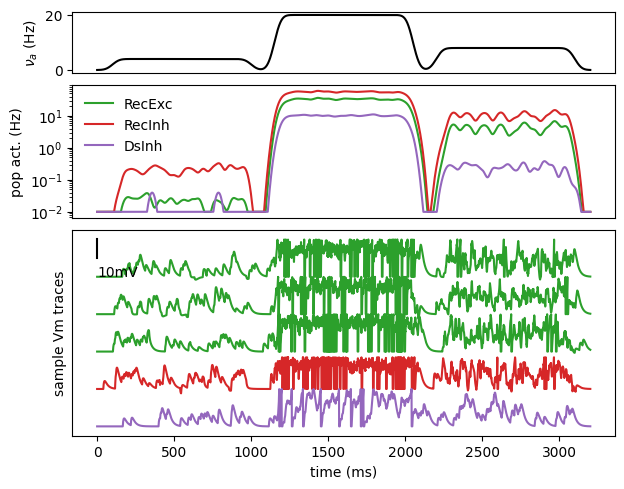

In [8]:
# import argparse
# parser=argparse.ArgumentParser(description="""
# Demo file for the paper: 
# "The Spectrum of Asynchronous Dynamics in Spiking Networks: A Theory for the Diversity of Non-Rhythmic Waking States"
# Zerlaut et al., 2018
# Reproducing Figure 3
# """,formatter_class=argparse.RawTextHelpFormatter)
# parser.add_argument("-v", "--verbose", help="print stuff",
#                     action="store_true")

# args = parser.parse_args()
NTWK = run_3pop_ntwk_model(Model,
                            with_Vm=3,
                            verbose=True)

### PLOT ###
fig = plt.figure(figsize=(7,5.5))
plt.subplots_adjust()
# afferent stimulation
ax1 = plt.subplot2grid((6,1), (0,0))
ax1.plot(NTWK['t_array'], NTWK['faff_waveform'], 'k-')
ax1.set_xticks([]);ax1.set_ylabel(r'$\nu_a$ (Hz)')
# populations activity (instant. firing rates)
ax2 = plt.subplot2grid((6,1), (1, 0), rowspan=2)
COLORS = ['#2ca02c', '#d62728', '#9467bd']
for i, pop in enumerate(['RecExc', 'RecInh', 'DsInh']):
    rate = NTWK['POP_ACT'][i].rate/brian2.Hz
    rate = gaussian_filter1d(rate, int(20./0.1)) # smoothing
    rate[rate<0.01] = 0.01
    ax2.semilogy(NTWK['t_array'], rate, '-', color=COLORS[i], label=pop)
ax2.legend(frameon=False)
ax2.set_xticks([]);ax2.set_ylabel('pop act. (Hz)')
# sample Vm traces 
ax3 = plt.subplot2grid((6,1), (3, 0), rowspan=3)
N = [3,1,1] # number displayed per population
j=0 # index to shift the Vm trace
for i, pop in enumerate(['RecExc', 'RecInh', 'DsInh']):
    for n in range(N[i]):
        ax3.plot(NTWK['t_array'], NTWK['VMS'][i].V[n]/brian2.mV-20*j, '-', color=COLORS[i])
        j+=1
ax3.plot([0.09, 0.09], [-60, -50], 'k-')
ax3.annotate('10mV', (0.1, -70))
ax3.set_yticks([]);ax3.set_ylabel('sample Vm traces')
ax3.set_xlabel('time (ms)')
plt.show()
    

In [9]:
WAVE = {
    'Faff1':4.,'Faff2':20.,'Faff3':8.,
    'DT':900., 'rise':50.
}

t_array = np.arange(int(3000/0.1))*0.1

In [29]:
def waveform(t, Model):
    waveform = 0*t
    # first waveform
    for tt, fa in zip(2.*Model['rise']+np.arange(3)*(3.*Model['rise']+Model['DT']), [Model['Faff1'], Model['Faff2'], Model['Faff3']]):
        waveform += fa*\
             (1+scipy.special.erf((t-tt)/Model['rise']))*\
             (1+scipy.special.erf(-(t-tt-Model['DT'])/Model['rise']))/4
    return waveform

z = waveform(t_array, WAVE)     

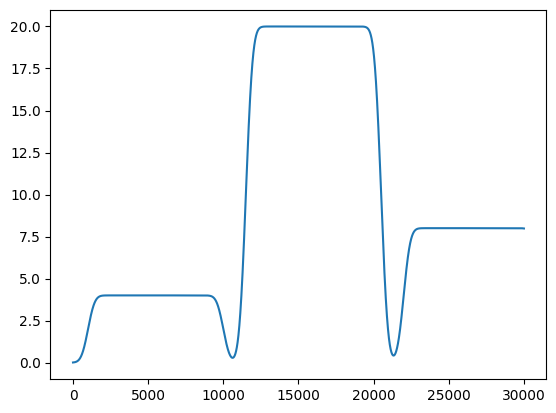

In [30]:
plt.plot(z)

In [28]:
2.*WAVE['rise']+np.arange(3)

array([100., 101., 102.])

In [21]:
Model = WAVE
2.*Model['rise']+np.arange(3)*(3    .*Model['rise']+Model['DT'])

array([ 100., 1150., 2200.])

In [22]:
t_array

array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 2.9997e+03, 2.9998e+03,
       2.9999e+03], shape=(30000,))

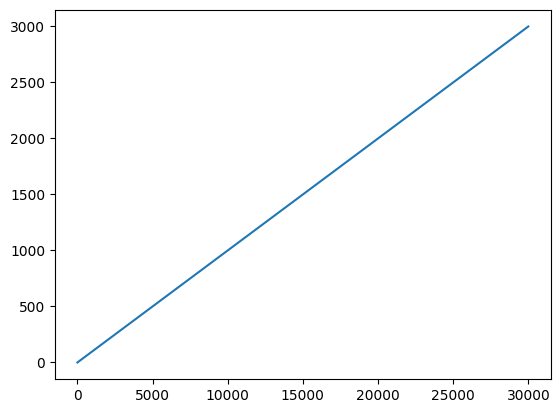

In [24]:
plt.plot(t_array)

In [27]:
waveform = 0*t_array